Задача заключается в прогнозировании веса рыбы по ее параметрам(вид, длина, высота, ширина и прочее
)

In [2]:
import pandas as pd
import seaborn as sns
import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
path = "fish_train.csv"
fish_data = pd.read_csv(path)
fish_data

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Roach,150.0,20.4,22.0,24.7,5.8045,3.7544
1,Perch,250.0,25.4,27.5,28.9,7.2828,4.5662
2,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
3,Bream,925.0,36.2,39.5,45.3,18.7542,6.7497
4,Perch,110.0,19.0,21.0,22.5,5.6925,3.5550
...,...,...,...,...,...,...,...
114,Parkki,273.0,23.0,25.0,28.0,11.0880,4.1440
115,Pike,500.0,42.0,45.0,48.0,6.9600,4.8960
116,Whitefish,1000.0,37.3,40.0,43.5,12.3540,6.5250
117,Perch,120.0,20.0,22.0,23.5,6.1100,3.4075


Линейные модели достаточно плохо реагируют на коррелированные признаки
Построим матрицу корреляции, для нахождения и дальнейшей обработки наиболее коррелированных признаков

In [4]:
fish_data.drop(columns = ["Species"]).corr() # отбросили нечисловой признак "Species" 

,Weight,Length1,Length2,Length3,Height,Width
Weight,1.000000,0.897306,0.900856,0.907401,0.745870,0.896493
Length1,0.897306,1.000000,0.999457,0.991043,0.621868,0.862072
Length2,0.900856,0.999457,1.000000,0.993469,0.638003,0.868714
Length3,0.907401,0.991043,0.993469,1.000000,0.704594,0.872468
Height,0.745870,0.621868,0.638003,0.704594,1.000000,0.783475
Width,0.896493,0.862072,0.868714,0.872468,0.783475,1.000000


Применим PCA к трем наиболее коррелированным признакам

In [5]:
pca = PCA(n_components=1, svd_solver='full')
xpca = pca.fit_transform(fish_data [['Length1', 'Length2', 'Length3']])
print(pca.explained_variance_ratio_) 
# доля объясненной дисперсии при использовании только первой главной компоненты

[0.99627616]


In [6]:
new_data = fish_data.drop(columns = ["Length1", "Length2", "Length3"])
new_data["Length"] = xpca

Построим зависимости массы рыбы от параметров

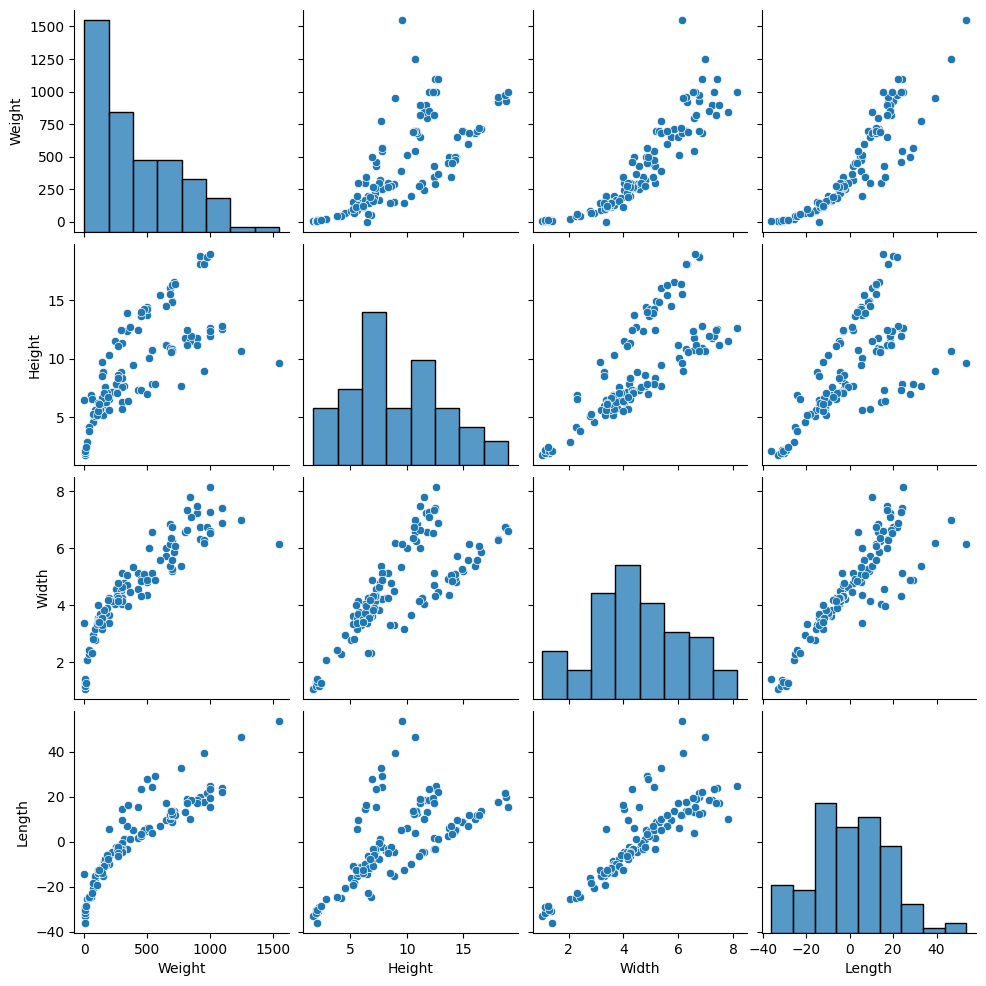

In [7]:
sns.pairplot(new_data.drop(columns =["Species"]))

Данные имеют скорее кубическую зависимость нежели линейную поэтому перед применением лр разумно было бы возвести в куб данные параметры

In [8]:
new_data["Width^3"] = new_data["Width"]**3
new_data["Height^3"] = new_data["Height"]**3
new_data = new_data.drop(columns = [ "Width", "Height"])

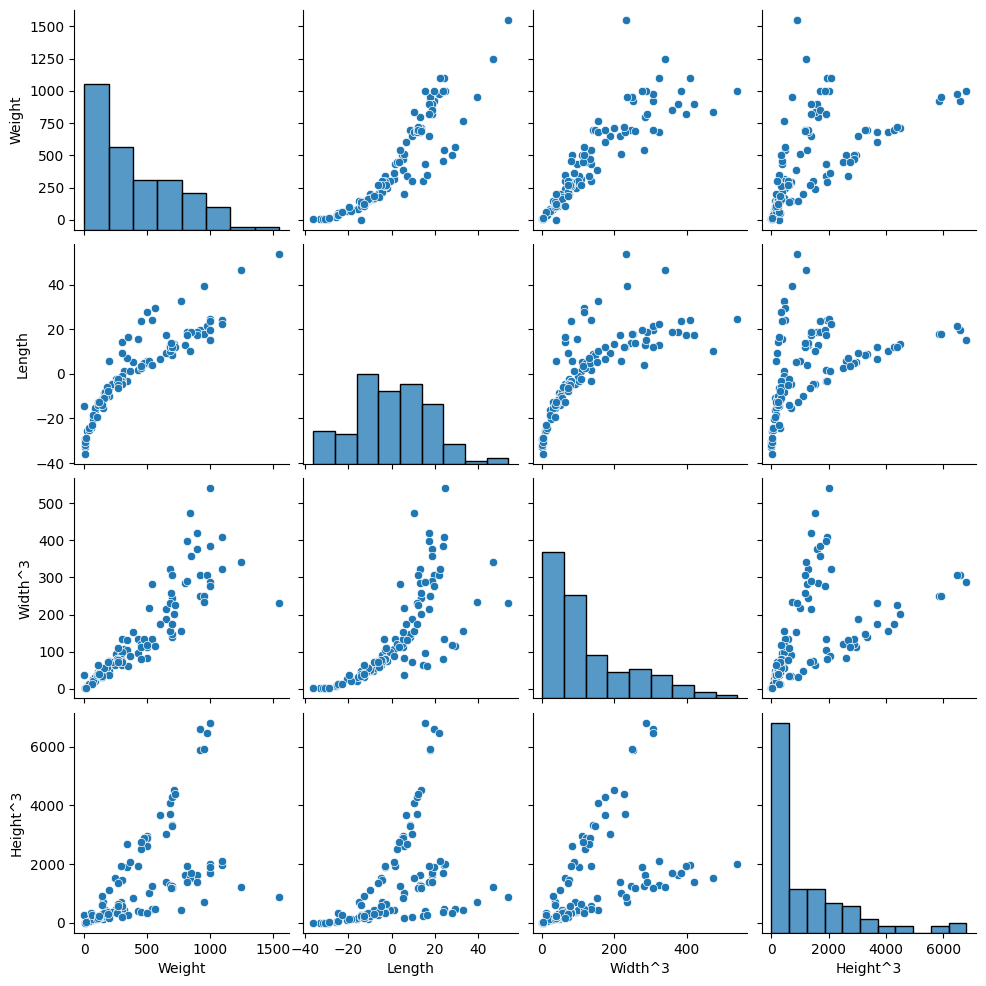

In [9]:
sns.pairplot(new_data.drop(columns =["Species"]))

In [10]:
new_data

,Species,Weight,Length,Width^3,Height^3
0,Roach,150.0,-11.486348,52.920218,195.566492
1,Perch,250.0,-3.048526,95.206103,386.273710
2,Bream,430.0,1.557884,135.321746,1926.992424
3,Bream,925.0,19.779440,307.505871,6596.227555
4,Perch,110.0,-14.171988,44.928179,184.462936
...,...,...,...,...,...
114,Parkki,273.0,-6.327814,71.163818,1363.200233
115,Pike,500.0,27.717784,117.361115,337.153536
116,Whitefish,1000.0,19.542476,277.805953,1885.483738
117,Perch,120.0,-12.442929,39.564674,228.099131


Разобьём данные на обучающую и тестовую выборку

In [11]:
train, test = train_test_split(new_data,
                test_size=0.2,
                train_size=0.8,
                random_state=1,
                shuffle=True,
                stratify=fish_data["Species"])

Также произведем  one-hot кодирование категориального признака "Species"

In [12]:
train_x = pd.get_dummies(data = train, drop_first=True).drop(columns=["Weight"])
train_y = train["Weight"]
test_x = pd.get_dummies(data = test, drop_first=True).drop(columns=["Weight"])
test_y = test["Weight"]

Итоговая точность модели

In [13]:
reg = LinearRegression().fit(train_x, train_y)
r2_score(test_y, reg.predict(test_x))

0.9498962607520102

Теперь посмотрим на результат катбуста который можно получить в несколько строчек кода без предобработки данных

In [14]:
cat_train, cat_test = train_test_split(fish_data,
                test_size=0.2,
                train_size=0.8,
                random_state=1,shuffle=True,
                stratify=fish_data["Species"])

cat_train_y = cat_train["Weight"]
cat_train_x = cat_train.drop(columns = ["Weight"])
cat_test_y = cat_test["Weight"]
cat_test_x = cat_test.drop(columns = ["Weight"])

In [15]:
cat_train_pool = cb.Pool(cat_train_x, 
                  cat_train_y, 
                  cat_features=[0])

cat_test_pool = cb.Pool(cat_test_x, 
                  cat_test_y, 
                  cat_features=[0])

In [16]:
model = cb.CatBoostRegressor(iterations=2000, 
                          depth=2, 
                          learning_rate=0.1, 
                          loss_function='RMSE')

In [17]:
model.fit(cat_train_pool)
preds = model.predict(cat_test_pool)

0:	learn: 306.0322513	total: 154ms	remaining: 5m 7s
1:	learn: 286.8023138	total: 163ms	remaining: 2m 43s
2:	learn: 268.0726432	total: 172ms	remaining: 1m 54s
3:	learn: 249.1618959	total: 186ms	remaining: 1m 33s
4:	learn: 233.5373727	total: 197ms	remaining: 1m 18s
5:	learn: 220.5318599	total: 210ms	remaining: 1m 9s
6:	learn: 206.9554117	total: 220ms	remaining: 1m 2s
7:	learn: 194.3761818	total: 244ms	remaining: 1m
8:	learn: 183.9137714	total: 257ms	remaining: 57s
9:	learn: 174.0751735	total: 269ms	remaining: 53.6s
10:	learn: 165.3004993	total: 281ms	remaining: 50.8s
11:	learn: 156.9232394	total: 298ms	remaining: 49.4s
12:	learn: 149.2876175	total: 325ms	remaining: 49.6s
13:	learn: 142.1047873	total: 365ms	remaining: 51.7s
14:	learn: 135.4014668	total: 386ms	remaining: 51.1s
15:	learn: 129.2303684	total: 404ms	remaining: 50.1s
16:	learn: 124.8876664	total: 417ms	remaining: 48.6s
17:	learn: 120.2257132	total: 438ms	remaining: 48.2s
18:	learn: 116.9416668	total: 456ms	remaining: 47.5s
19:	

In [18]:
print(r2_score(cat_test_y, preds))

0.9837649848861477
